In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
%matplotlib inline


In [2]:
df = pd.read_csv("BBC News Train.csv")

In [3]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


<b> Assigning category names to the numeric values and storing them in new column so that further calculation can be simpler. For this we will use factorize() method of pandas </b>

In [6]:
df['category_id'] = df['Category'].factorize()[0]

In [7]:
df['category_id'][0:10]

0    0
1    0
2    0
3    1
4    0
5    2
6    3
7    4
8    0
9    4
Name: category_id, dtype: int64

<b> Creating a new dataframe which only contains the unique categories along with their category id </b>

In [9]:
unique_category_df = df[['Category','category_id']].drop_duplicates().sort_values('category_id')

In [10]:
unique_category_df

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


<b> Creating a dictionary to map category name to the category id and vice versa </b>

In [11]:
category_to_id = dict(unique_category_df.values)
id_to_category = dict(unique_category_df[['category_id','Category']].values)

In [12]:
category_to_id

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [13]:
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

<b> Counting the no. of articles under each category</b> 

In [14]:
df.groupby('Category').category_id.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

<b> Doing exloratory data analysis</b>

<AxesSubplot:xlabel='Category'>

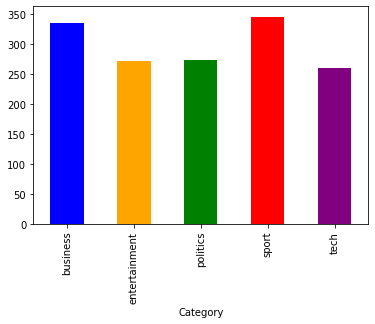

In [17]:
df.groupby('Category').category_id.count().plot.bar(ylim = 0 , color = ['blue','orange','green','red','purple'] )

<b> Tokenizing our data using TFidfVectorizer</b>

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding = 'latin-1', stop_words = 'english', ngram_range = (1,2), min_df = 5, norm = 'l2', sublinear_tf = True)

# Remapping the words in the dataset in the text column of data frames into features(superset of words) with an importance assigned based on each word's frequency in the document 
features = tfidf.fit_transform(df.Text).toarray()

#representing the category of each article
labels = df.category_id

In [23]:
features.shape

(1490, 9927)

In [24]:
sorted(category_to_id.items())

[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

<b> Finding corelation between features(importance of words) and labels(categories) using chi - square analysis </b>

In [27]:
from sklearn.feature_selection import chi2

N = 3 # printing only top 3 corelated words

# finding words that are highly corelated to each other for each category

for Category, category_id in sorted(category_to_id.items()) :
    
    # do chi analysis for all the items in this category
    features_chi2 = chi2(features, labels == category_id)
    
    # sorting the indices of features_chi2[0] - the chi-squared stats of each feature
    indices = np.argsort(features_chi2[0])
    
    # converting the indices to feature names
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    # listing single word features
    unigrams = [ v for v in feature_names if len(v.split(' ')) == 1]
    
    # listing 2-word features
    bigrams = [ v for v in feature_names if len(v.split(' ')) == 2]
    
    print(" --> '{}' :".format(Category))
    print("\t Most correlated unigrams :\n\t\t -{}".format('\n\t\t -'.join(unigrams[-N:])))
    print("\t Most correlated bigrams :\n\t\t -{}".format('\n\t\t -'.join(bigrams[-N:])))

 --> 'business' :
	 Most correlated unigrams :
		 -growth
		 -bank
		 -shares
	 Most correlated bigrams :
		 -stock market
		 -economic growth
		 -analysts said
 --> 'entertainment' :
	 Most correlated unigrams :
		 -singer
		 -actor
		 -film
	 Most correlated bigrams :
		 -won best
		 -los angeles
		 -box office
 --> 'politics' :
	 Most correlated unigrams :
		 -blair
		 -election
		 -labour
	 Most correlated bigrams :
		 -prime minister
		 -tony blair
		 -mr blair
 --> 'sport' :
	 Most correlated unigrams :
		 -match
		 -coach
		 -cup
	 Most correlated bigrams :
		 -grand slam
		 -champions league
		 -australian open
 --> 'tech' :
	 Most correlated unigrams :
		 -technology
		 -software
		 -users
	 Most correlated bigrams :
		 -anti virus
		 -mobile phones
		 -mobile phone


In [28]:
features_chi2

(array([0.13345481, 0.01563765, 0.00108776, ..., 0.00812363, 0.15434356,
        0.120306  ]),
 array([0.71487652, 0.9004835 , 0.97368962, ..., 0.92818297, 0.69441858,
        0.72870284]))

<b> Sampling a subset of dataset using t-SNE. Also t-SNE is computationally expensive so using 30% of the dataset </b>

In [31]:
from sklearn.manifold import TSNE

sample_size = int(len(features) * 0.3)
np.random.seed(0)

# randomly selecting 30% of the sample
indices = np.random.choice(range(len(features)), size = sample_size, replace= False)

# printing array of all projected features of 30% of the randomly chosen samples
projected_features = TSNE(n_components = 2, random_state = 0).fit_transform(features[indices])

In [32]:
c_id = 0 # choosing a category
projected_features[(labels[indices] == c_id).values]

array([[-17.409828  , -20.436989  ],
       [ -9.56882   , -11.314312  ],
       [-17.156994  ,  -6.452465  ],
       [-10.862223  , -21.660397  ],
       [-19.501608  ,   4.6090965 ],
       [-11.990335  , -16.382895  ],
       [-27.134926  ,  -2.8496113 ],
       [ -9.668595  , -17.357132  ],
       [  8.465661  ,  -9.051764  ],
       [-19.876314  ,  -9.820042  ],
       [  2.6430216 ,   3.9847393 ],
       [-15.166494  , -10.5767145 ],
       [ 15.052534  , -22.136509  ],
       [-29.180244  , -15.261823  ],
       [-11.231472  , -24.399818  ],
       [-13.417371  , -11.908246  ],
       [ -8.409627  , -11.635613  ],
       [-11.572334  , -18.307085  ],
       [-17.998095  , -14.864076  ],
       [-26.832064  ,  -5.992347  ],
       [ -0.91015923, -20.449903  ],
       [-23.755339  , -14.732829  ],
       [-17.284416  ,  -6.835661  ],
       [-22.186396  , -10.912631  ],
       [-11.207357  , -14.555125  ],
       [-25.065447  , -10.098723  ],
       [-22.816729  , -12.928076  ],
 

<b> Plotting the tf-idf feature vector for each article </b>

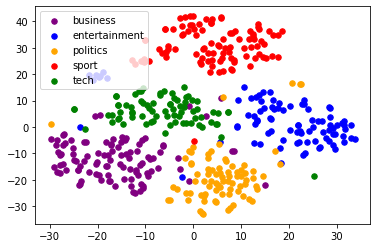

In [33]:
colors = ['purple', 'green', 'orange', 'red', 'blue']

for category, category_id in sorted(category_to_id.items()) :
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s = 30, color = colors[category_id], label=category)
    plt.legend()

<b> Training the model </b>


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0), MultinomialNB, LogisticRegression(random_state = 0)]

In [37]:
# CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

# #Create a data frame that will store the results for all 5 trials of the 3 different models
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = [] # Initially all entries are empty

In [41]:
# #For each Algorithm 
# for model in models:
#     model_name = model.__class__.__name__
#     # create 5 models with different 20% test sets, and store their accuracies
#     accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#     # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
#     for fold_idx, accuracy in enumerate(accuracies):
#         entries.append((model_name, fold_idx, accuracy))

In [45]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state = 0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size = 0.33, random_state =0)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

<b> Analysing predictions </b>

Text(0.5, 15.0, 'Predicted')

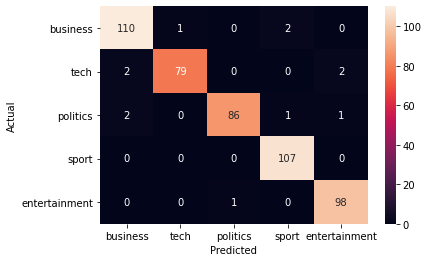

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=unique_category_df.Category.values, yticklabels=unique_category_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [50]:
model.fit(features, labels)

LogisticRegression(random_state=0)

In [52]:
model.coef_ # coef contains the importance of each feature for each category

array([[ 0.46799432,  0.01813872, -0.0715333 , ..., -0.03318298,
         0.0068823 , -0.02849203],
       [-0.02957523, -0.04366737, -0.01371468, ...,  0.00362675,
        -0.02877942, -0.02070068],
       [ 0.05006025, -0.05159908, -0.04674601, ..., -0.00638322,
        -0.03112648, -0.02362395],
       [-0.61687406, -0.04152046, -0.05352312, ...,  0.08450437,
         0.08574049,  0.09981232],
       [ 0.12839471,  0.11864819,  0.18551711, ..., -0.04856492,
        -0.03271689, -0.02699566]])

In [55]:
N = 5 

for Category, category_id in sorted(category_to_id.items()) :
    
    indices = np.argsort(model.coef_[category_id])
    
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [ v for v in reversed(feature_names) if len(v.split(' ')) == 1]
    
    bigrams = [ v for v in reversed(feature_names) if len(v.split(' ')) == 2]
    
    print(" --> '{}' :".format(Category))
    print("\t Top unigrams :\n\t\t -{}".format('\n\t\t -'.join(unigrams[:N])))
    print("\t Top bigrams :\n\t\t -{}".format('\n\t\t -'.join(bigrams[:N])))

 --> 'business' :
	 Top unigrams :
		 -firm
		 -bank
		 -company
		 -shares
		 -market
	 Top bigrams :
		 -chief executive
		 -analysts said
		 -stock market
		 -economic growth
		 -oil prices
 --> 'entertainment' :
	 Top unigrams :
		 -film
		 -music
		 -singer
		 -star
		 -band
	 Top bigrams :
		 -box office
		 -los angeles
		 -film festival
		 -new york
		 -big brother
 --> 'politics' :
	 Top unigrams :
		 -labour
		 -mr
		 -party
		 -election
		 -government
	 Top bigrams :
		 -mr blair
		 -prime minister
		 -tony blair
		 -general election
		 -mr brown
 --> 'sport' :
	 Top unigrams :
		 -match
		 -win
		 -game
		 -coach
		 -cup
	 Top bigrams :
		 -year old
		 -australian open
		 -champions league
		 -world cup
		 -grand slam
 --> 'tech' :
	 Top unigrams :
		 -users
		 -software
		 -computer
		 -technology
		 -online
	 Top bigrams :
		 -said mr
		 -news website
		 -bbc news
		 -mobile phone
		 -mobile phones


In [61]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'business'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'



In [63]:
import os

test_df = pd.read_csv("BBC News Test.csv")

In [64]:
test_features = tfidf.transform(test_df.Text.tolist())

Y_pred = model.predict(test_features)

Y_pred

array([3, 1, 3, 0, 3, 3, 2, 2, 4, 0, 0, 1, 2, 1, 4, 3, 2, 1, 4, 4, 0, 2,
       3, 0, 2, 3, 0, 3, 3, 0, 2, 1, 0, 0, 3, 3, 3, 0, 4, 4, 1, 2, 4, 1,
       3, 1, 4, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 4, 3, 1, 3, 4, 1, 2, 0, 4,
       3, 1, 3, 3, 0, 3, 0, 2, 1, 3, 1, 1, 1, 4, 2, 3, 4, 4, 0, 4, 0, 4,
       0, 1, 0, 2, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 2, 4, 0, 3, 2, 3, 2, 4,
       3, 0, 4, 3, 2, 3, 2, 3, 2, 0, 4, 0, 4, 4, 1, 3, 0, 4, 0, 4, 0, 2,
       2, 1, 0, 0, 2, 1, 4, 3, 0, 1, 3, 4, 2, 3, 3, 4, 4, 1, 0, 1, 2, 4,
       3, 3, 3, 3, 4, 1, 0, 1, 0, 1, 0, 1, 4, 1, 1, 2, 0, 2, 0, 0, 4, 2,
       1, 0, 0, 1, 3, 2, 3, 2, 1, 1, 2, 0, 2, 4, 2, 0, 4, 3, 1, 1, 0, 1,
       2, 0, 3, 2, 0, 4, 0, 0, 3, 1, 0, 3, 4, 4, 3, 4, 3, 1, 2, 4, 3, 4,
       3, 4, 2, 0, 1, 4, 0, 2, 0, 1, 0, 3, 2, 2, 0, 2, 3, 0, 4, 2, 3, 2,
       0, 3, 1, 0, 2, 0, 2, 0, 0, 3, 1, 2, 4, 1, 4, 1, 3, 3, 1, 3, 3, 3,
       4, 3, 2, 1, 0, 3, 0, 3, 0, 3, 4, 0, 0, 4, 2, 0, 3, 3, 1, 3, 3, 4,
       0, 3, 1, 2, 4, 0, 0, 2, 3, 4, 2, 0, 3, 3, 1,

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       113
           1       0.99      0.95      0.97        83
           2       0.99      0.96      0.97        90
           3       0.97      1.00      0.99       107
           4       0.97      0.99      0.98        99

    accuracy                           0.98       492
   macro avg       0.98      0.97      0.98       492
weighted avg       0.98      0.98      0.98       492

[[110   1   0   2   0]
 [  2  79   0   0   2]
 [  2   0  86   1   1]
 [  0   0   0 107   0]
 [  0   0   1   0  98]]
